# Análise de Dados Exploratória da ANAC

![ANAC](imgs/anac-logo.png "Logo ANAC")

# 1. Introdução

Este estudo tem como objetivo analisar um conjunto de dados de voos internacionais registrados pela Agência Nacional de Aviação Civil (ANAC) do Brasil, durante o período de janeiro de 2015 a agosto de 2017. 

A ANAC é a agência reguladora responsável pela aviação civil no país, e as informações contidas nesses dados são de grande importância para a compreensão da dinâmica da aviação internacional no Brasil, bem como para a tomada de decisões estratégicas no setor. O conjunto de dados inclui informações como o número do voo, nome da companhia aérea, horários de partida e chegada previstos e reais, situação do voo e localização dos aeroportos de origem e destino, entre outros. Esses dados permitem uma análise detalhada das tendências e padrões de voos internacionais no Brasil, bem como a identificação de fatores que possam influenciar o desempenho da aviação internacional no país.

## 1.1. Objetivos

O objetivo deste estudo é realizar uma Análise Exploratória dos Dados (Exploratory Data Analysis - EDA) do conjunto de dados disposto em [bases/](bases/), e analisar dados de voos internacionais rastreados pela ANAC.

Com base nas informações disponíveis, pretendemos avaliar o desempenho das companhias aéreas em relação ao cumprimento dos horários previstos de partida e chegada, bem como investigar a frequência de cancelamentos e as justificativas apresentadas para esses casos. 

Também vamos examinar as rotas mais utilizadas e os destinos mais comuns para os voos internacionais saindo do Brasil, bem como avaliar a pontualidade e a eficiência dos aeroportos de origem e destino. 

1. [3.1. Qual destino mais procurado nas férias? (julho, dezembro e janeiro)](#)
1. [3.1.1. Principais destinos regionais](#)
1. [3.1.2. Principais destinos nacionais](#)
1. [3.1.3. Principais destinos internacionais](#)
1. [3.2. Como ficam os aeroportos nesses meses?](#)
1. [3.2.1. Atrasos](#)
1. [3.2.2. Cancelamentos](#)
1. [3.2.1. Atrasos](#)
1. [3.3. Qual a melhor opção uma viagem nacional ou internacional?](#)
1. [3.4. Qual a melhor rota?](#)
1. [3.5. Qual melhor dia da semana para pegar um vôo?](#)


# 2. Metodologia

Nesta seção será apresentado todo o processo de preparação, organização e limpeza de dados feito no *dataset* que possui os seguintes dados brutos. Ao final desta, apresentaremos os dados padronizados e devidamente tratados:

|        Coluna        | Tipo |                         Descrição                         |
|:--------------------:|:----:|:---------------------------------------------------------:|
|         Voos         |  str |                       Número do voo                       |
|    Companhia.Aerea   |  str |                  Nome da companhia aérea                  |
|   Codigo.Tipo.Linha  |  str |          Código do tipo de linha (internacional)          |
|   Partida.Prevista   |  str |                Horário previsto de partida                |
|     Partida.Real     |  str |                  Horário real de partida                  |
|   Chegada.Prevista   |  str |                Horário previsto de chegada                |
|     Chegada.Real     |  str |                  Horário real de chegada                  |
|     Situacao.Voo     |  str |        Situação do voo (realizado, cancelado, etc)        |
| Codigo.Justificativa |  str | Código de justificativa (caso o voo tenha sido cancelado) |
|   Aeroporto.Origem   |  str |               Código do aeroporto de origem               |
|     Cidade.Origem    |  str |                      Cidade de origem                     |
|     Estado.Origem    |  str |                      Estado de origem                     |
|      Pais.Origem     |  str |                       País de origem                      |
|   Aeroporto.Destino  |  str |               Código do aeroporto de destino              |
|    Cidade.Destino    |  str |                     Cidade de destino                     |
|    Estado.Destino    |  str |                     Estado de destino                     |
|     Pais.Destino     |  str |                      País de destino                      |
|       LongDest       |  str |             Longitude do aeroporto de destino             |
|        LatDest       |  str |              Latitude do aeroporto de destino             |
|       LongOrig       |  str |              Longitude do aeroporto de origem             |
|        LatOrig       |  str |              Latitude do aeroporto de origem              |


## 2.1. Configuração do Ambiente

### 2.1.1. Bibliotecas e Ferramentas Necessárias (Built-ins)

1. ```os```:       Para manipular os arquivos de base e seus respectivos diretórios de forma multiplataforma e eficiente.
2. ```re```:       Utilizado em expressões regulares durante o processo de limpeza dos dados.
3. ```enum```:     Auxilia nos processos de padronizar e regular algumas convenções do projeto.
4. ```datetime```, ```time```: Auxilia nos processos de padronizar e regular algumas convenções do projeto.
4. ```typing```: definir tipos em documentações e assinaturas.

### 2.1.2. Bibliotecas e Ferramentas Necessárias (pip)

1. Pandas: Para manipular e exibir os dados de forma coesa e relata.   
    ```pip install pandas```       
    ```import pandas as pd```

2. JinJa2: Complemento de estilização do Pandas.   
    ```pip install Jinja2```

4. Utils: Contém uma série de métodos auxiliares nos processos de organização, limpeza e feature engineering.     
    ```from libs.utils import Utils```

5. Plot: Contém os métodos e regras de negócio para plotar os gráficos.     
    ```from libs.utils import Plot```

5. AnacVoos: Contém Responsável por armazenar,controlar e servir os dados.     
    ```from libs.utils import AnacVoos```

### 2.1.3. Demais bibliotecas em ```libs.utils```:

  
1.    **enum**:               ```from enum import Enum```     

1.    **datetime**:           ```from datetime import datetime```     

1.    **typing**:             ```from typing import Any, Callable, List, Dict, Tuple```     

1.    **numpy**:              ```import numpy```     

1.    **matplotlib.pyplot**:  ```import matplotlib.pyplot```     

1.    **mplcyberpunk**:       ```pip install mplcyberpunk``` | ```import mplcyberpunk```  |

### 2.1.4. Importações gerais para o projeto

In [1]:
import os
import re
import time
import pandas as pd
from libs.utils import Utils, Plot, AnacVoos

## 2.2. Carregamento da base

In [2]:
caminho = os.path.join(
    os.path.dirname(
        os.path.abspath(
            os.path.join(__name__, '.'))), 'bases')

arquivos = [arquivo for arquivo in os.listdir(
    caminho) if arquivo.endswith(".csv")]

dataframes = [pd.read_csv(os.path.join(caminho, arquivo))
              for arquivo in arquivos]

AnacVoos.dados = pd.concat(dataframes)
AnacVoos.total_arquivos = len(arquivos)
AnacVoos.dados_solidos = False
AnacVoos.total_registros = len(AnacVoos.dados.index)
AnacVoos.tempo_execucao = time.time()

## 2.3. Organização e Limpeza dos Dados

### 2.3.1. Padrozinação dos nomes das colunas

In [3]:
nomes_colunas_tratadas = []

for coluna in AnacVoos.dados.columns:
    if any(char.isupper() for char in coluna):
        if coluna == 'Voos':
            coluna = 'Num.Voo'
        nomes_colunas_tratadas.append('_'.join(word.lower() for word in re.findall(
            '[A-Z][^A-Z]*', coluna)).lower().replace('.', ''))

AnacVoos.dados.columns = nomes_colunas_tratadas

### 2.3.2. Padrozinação dos tipos das colunas de data/hora, string e númericos

In [4]:
for coluna in AnacVoos.dados.columns:
    tipo = Utils.tipo_coluna(coluna)
    if tipo.__name__ == 'datetime':
        AnacVoos.dados = Utils.formatar_colunas_datetime(
            AnacVoos.dados, coluna)

### 2.3.3. Padrozinação no nome das companhias aérea.

In [5]:
AnacVoos.dados['companhia_aerea'] = AnacVoos.dados.apply(
    lambda row: Utils.nome_companhia_aerea_normalizado(
        row['companhia_aerea'],
    ), axis=1)

### 2.3.4. Padrozinação dos tipos de linhas: `Nacional`, `Internacional`.

In [6]:
AnacVoos.dados['codigo_tipo_linha'] = AnacVoos.dados.apply(
    lambda row: Utils.tipo_linha_normalizado(
        row['codigo_tipo_linha'],
    ), axis=1)


### 2.3.4. Feature Engineering
A engenharia de recursos (*Feature Engineering*) é o processo de usar o conhecimento do domínio para extrair recursos dos dados brutos. Neste estudo serão acrescentadas as seguintes colunas para enriquecer a análise de dados:

| Coluna         | Descrição                                                            | Base         |
|:--------------:|:--------------------------------------------------------------------:|:--------------:|
| partida_atrasou | Houve atraso na partida (S/N)                                       | `partida_prevista - partida_real` |
| chegada_atrasou | Houve atraso na chegada (S/N)                                       | `chegada_prevista - chegada_real` |
| distancia_km   | Distância total em kms da origem ao destino                          | `lat_long_orig - lat_long_dest` |
| justificativa_atraso   | Informação e correlata à justificativa no atraso do voo      | `codigo_justificativa` |
| justificativa_cancelamento   | Informação e correlata à justificativa do cancelamento do voo| `codigo_justificativa` |
| rota           | Origem x Destino                                                     | `x_origem + x_destino` |
| periodo_ferias           | Contém o mês condizente a um período de férias (Janeiro, Julho ou Dezembro)    | `partida_prevista` **in** [1, 7, 12]  |
| dia_semana           | Contém o dia da semana para data de partida    | `partida_prevista`  |
| tempo_atraso_partida           | Contém o tempo total do atraso na partida  | `partida_prevista` - `partida_real`  |
| tempo_atraso_chegada           | Contém o tempo total do atraso na chegada    | `chegada_prevista` - `chegada_real`  |

#### 2.3.3.1. Atraso na partida

In [7]:
AnacVoos.dados['partida_atrasou'] = AnacVoos.dados.apply(
    lambda row: Utils.validar_atraso(
        row['situacao_voo'],
        row['partida_prevista'],
        row['partida_real']
    ), axis=1)

##### 2.3.3.1.1 Cálculo tempo de atraso na partida

In [8]:
AnacVoos.dados['tempo_atraso_partida'] = AnacVoos.dados.apply(
    lambda row: Utils.calcular_atraso(
        row['partida_atrasou'],
        row['partida_prevista'],
        row['partida_real']
    ), axis=1)

#### 2.3.3.2. Atraso na chegada

In [9]:
AnacVoos.dados['chegada_atrasou'] = AnacVoos.dados.apply(
    lambda row: Utils.validar_atraso(
        row['situacao_voo'],
        row['chegada_prevista'],
        row['chegada_real']
    ), axis=1)

##### 2.3.3.2.1. Cálculo tempo de atraso na chegada

In [10]:
AnacVoos.dados['tempo_atraso_chegada'] = AnacVoos.dados.apply(
    lambda row: Utils.calcular_atraso(
        row['chegada_atrasou'],
        row['chegada_prevista'],
        row['chegada_real']
    ), axis=1)

##### 2.3.3.2.3. Contextualizando campo situação do voo

In [11]:
AnacVoos.dados['situacao_voo'] = AnacVoos.dados.apply(
    lambda row: Utils.atualizar_situacao_voo(
        row['situacao_voo'],
        row['partida_atrasou'],
        row['chegada_atrasou']
    ), axis=1)

#### 2.3.3.3. Calculando a distancia em km (para *lat_long_orig* e *lat_long_dest*)

In [12]:
AnacVoos.dados['distancia_km'] = AnacVoos.dados.apply(
    lambda row: Utils.calcular_distancia_km(
        row['lat_orig'],
        row['long_orig'],
        row['lat_dest'],
        row['long_dest']
    ), axis=1)

#### 2.3.3.4. Justificativa atraso

In [13]:
AnacVoos.dados['justificativa_atraso'] = AnacVoos.dados.apply(
    lambda row: Utils.atualizar_justificativa_atraso(
        row['partida_atrasou'],
        row['chegada_atrasou'],
        row['codigo_justificativa']
    ), axis=1
)

#### 2.3.3.5. Justificativa cancelamento

In [14]:
AnacVoos.dados['justificativa_cancelamento'] = AnacVoos.dados.apply(
    lambda row: Utils.atualizar_justificativa_cancelamento(
        row['situacao_voo'],
        row['codigo_justificativa']
    ), axis=1
)

#### 2.3.3.6. Rota

In [15]:
AnacVoos.dados['rota'] = AnacVoos.dados.apply(
    lambda row: Utils.criar_rota(
        row['codigo_tipo_linha'],
        row['pais_origem'],
        row['pais_destino'],
        row['estado_origem'],
        row['estado_destino'],
        row['cidade_origem'],
        row['cidade_destino']
    ), axis=1
)

#### 2.3.3.7. Período Férias

In [16]:
AnacVoos.dados['periodo_ferias'] = Utils.atribuir_periodo_ferias(
    AnacVoos.dados['partida_prevista'])

#### 2.3.3.8. Dia Semana

In [17]:
AnacVoos.dados['dia_semana'] = pd.to_datetime(
    AnacVoos.dados['partida_prevista'], dayfirst=True).dt.strftime('%A')

AnacVoos.dados['dia_semana'] = AnacVoos.dados['dia_semana'].apply(
    lambda row: Utils.atribuir_dia_semana(row)
)

## 2.4. Mapeamento de Dados
Para melhorar a análise e interpretação dos dados os seguintes atributos serão modificados:

| Coluna    | Original     | Modificado                          |
|:----------:|:-------------:|:------------------------------------:|
| *    | 'NA', *      | '', *                  |
| *      | np.NaN / NaN      | ''                  |


### 2.4.1. Removendo 'N/I' por um valor ''/string.empty

In [18]:
for coluna in AnacVoos.dados.columns:
    AnacVoos.dados[coluna] = AnacVoos.dados[coluna].replace('N/I', '')

### 2.4.2. Removendo np.NaN por um valor None

In [19]:
AnacVoos.dados.fillna(value='', inplace=True)

### 2.5. Reordenando as colunas de forma semântica

In [20]:
AnacVoos.dados = AnacVoos.dados.reindex(
    columns=Utils.nomes_colunas(), index=None)
AnacVoos.dados.drop('codigo_justificativa', axis=1, inplace=True)

# garantindo que não houveram alterações no volume de dados
AnacVoos.dados_solidos = len(AnacVoos.dados.index) == AnacVoos.total_registros

### 2.6 Resultado final

In [21]:
columns = ['NomeColuna', 'DescricaoColuna', 'TipoColuna']
values = [[value, Utils.descricao_coluna(value), Utils.tipo_coluna(
    value).__name__] for value in AnacVoos.dados.columns]

pd.DataFrame(data=values, columns=columns).style.set_table_styles([
    dict(selector='th', props=[('text-align', 'center')]),
    dict(selector='td', props=[('text-align', 'center')])
])

,NomeColuna,DescricaoColuna,TipoColuna
0,num_voo,Número do voo,str
1,companhia_aerea,Nome da companhia aérea,str
2,codigo_tipo_linha,Código do tipo de linha (internacional),str
3,rota,Origem x Destino,str
4,periodo_ferias,"Contém o mês condizente a um período de férias (Janeiro, Julho ou Dezembro)",str
5,dia_semana,Contém o dia da semana para data de partida,str
6,aeroporto_origem,Código do aeroporto de origem,str
7,cidade_origem,Cidade de origem,str
8,estado_origem,Estado de origem,str
9,pais_origem,País de origem,str


# 3. Análise dos Dados

## 3.1. Qual destino mais procurado nas férias?
Iremos analisar os principais destinos internacionais e nacionais e os períodos de julho, dezembro e janeiro.

In [22]:
# Dataframe
voos_ferias_agg = AnacVoos.get_voos_ferias_geral(
    filtrar_periodo_ferias=True,
    percentuais=[
        ['tx_realizados', 'realizados_s_atraso'],
        ['tx_atrasos', 'realizados_c_atraso'],
        ['tx_cancelados', 'cancelados']],
    round=2,
    cols_groupby=['codigo_tipo_linha', 'periodo_ferias'],
)

voos_ferias_agg = voos_ferias_agg.reindex(
    columns=['codigo_tipo_linha', 'periodo_ferias', 'voos', 'realizados_s_atraso',
             'tx_realizados', 'realizados_c_atraso', 'tx_atrasos', 'cancelados', 'tx_cancelados']
)

for periodo in AnacVoos.periodo_ferias():
    display(voos_ferias_agg.query("periodo_ferias == @periodo").nlargest(10,
            'voos').reset_index(drop=True))
    print()

,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,janeiro,81597,58075,0.71,14373,0.18,9149,0.11
1,Internacional,janeiro,11484,9540,0.83,1716,0.15,228,0.02


,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,julho,80587,55167,0.68,15669,0.19,9751,0.12
1,Internacional,julho,11379,8651,0.76,2172,0.19,556,0.05


,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,dezembro,80996,54113,0.67,15826,0.20,11057,0.14
1,Internacional,dezembro,11125,8601,0.77,1987,0.18,537,0.05


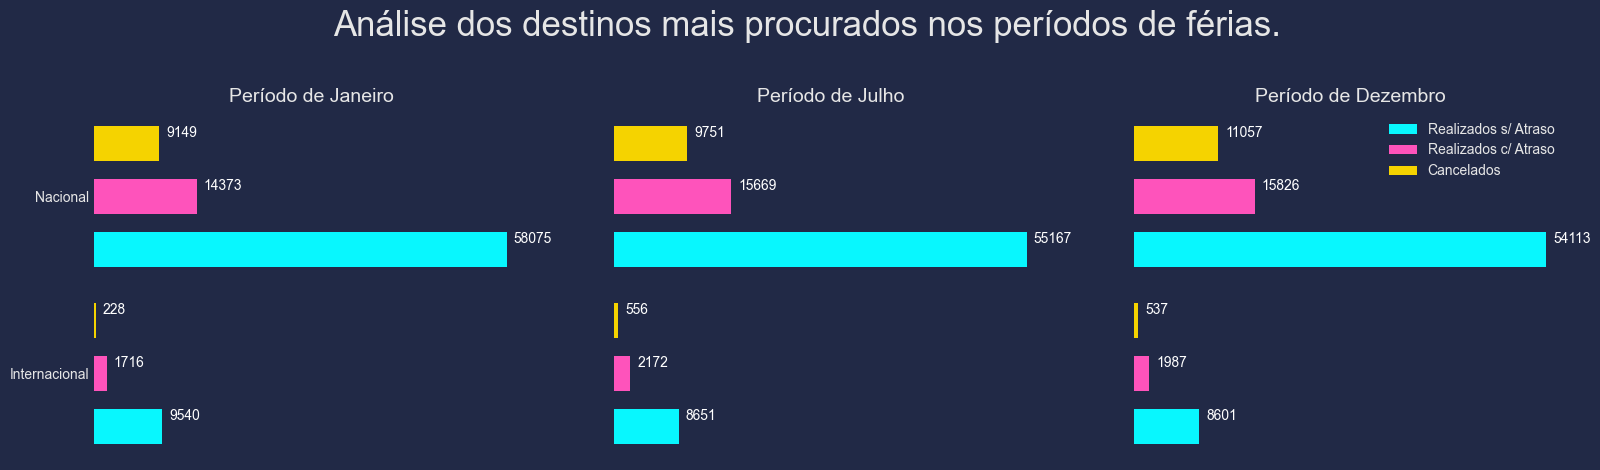

In [23]:
# Plot
Plot.periodo_ferias_geral(
    dataframe=voos_ferias_agg,
    periodo_ferias=AnacVoos.periodo_ferias(),
    grid=False,
    context='cyberpunk',
    figsize=(19, 10),
    suptitle='Análise dos destinos mais procurados nos períodos de férias.'
)

### 3.1.1 Principais destinos nacionais nos períodos de julho, dezembro e janeiro

In [24]:
# Dataframe
nacionais = list()
linha = 'Nacional'

for i, periodo in enumerate(AnacVoos.periodo_ferias()):
    nacionais.append(
        AnacVoos.get_voos_ferias_linha_periodo(
            cols_percentuais=[
                ['tx_realizados', 'realizados_s_atraso'],
                ['tx_atrasos', 'realizados_c_atraso'],
                ['tx_cancelados', 'cancelados']],
            cols_groupyby=['codigo_tipo_linha', 'periodo_ferias', 'rota'],
            linha=linha, 
            periodo=periodo,
            round=3
            )
        )
    print(f"10 Principais rotas nacionais no período de {periodo.title()}")
    display(nacionais[i])
    print()

nacionais: pd.DataFrame = pd.concat(nacionais)

10 Principais rotas nacionais no período de Janeiro


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,janeiro,SP - RJ,374.458921,2707,1974,0.729,523,0.193,210,0.078
1,Nacional,janeiro,RJ - SP,375.116650,2596,1777,0.685,614,0.237,205,0.079
2,Nacional,janeiro,SP - MG,490.929679,2578,1634,0.634,446,0.173,498,0.193
3,Nacional,janeiro,MG - SP,491.209767,2575,1712,0.665,350,0.136,513,0.199
4,Nacional,janeiro,SP - SP,314.088906,2216,1576,0.711,333,0.150,307,0.139
5,Nacional,janeiro,SP - PR,455.160217,2127,1408,0.662,420,0.197,299,0.141
6,Nacional,janeiro,PR - SP,465.339864,2104,1488,0.707,320,0.152,296,0.141
7,Nacional,janeiro,SC - SP,482.230319,1723,1277,0.741,308,0.179,138,0.080
8,Nacional,janeiro,MG - MG,306.936759,1721,776,0.451,128,0.074,817,0.475
9,Nacional,janeiro,SP - RS,848.189938,1713,1276,0.745,275,0.161,162,0.095



10 Principais rotas nacionais no período de Julho


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,julho,SP - RJ,373.091287,2708,1879,0.694,462,0.171,367,0.136
1,Nacional,julho,RJ - SP,373.706965,2588,1745,0.674,538,0.208,305,0.118
2,Nacional,julho,MG - SP,494.547083,2518,1614,0.641,501,0.199,403,0.160
3,Nacional,julho,SP - SP,322.000059,2506,1634,0.652,546,0.218,326,0.130
4,Nacional,julho,SP - MG,494.560450,2498,1685,0.675,448,0.179,365,0.146
5,Nacional,julho,SP - PR,474.707511,2125,1381,0.650,450,0.212,294,0.138
6,Nacional,julho,PR - SP,472.941298,2084,1374,0.659,470,0.226,240,0.115
7,Nacional,julho,SP - SC,481.361467,1808,1228,0.679,388,0.215,192,0.106
8,Nacional,julho,SC - SP,481.730059,1788,1255,0.702,363,0.203,170,0.095
9,Nacional,julho,SP - RS,848.184458,1728,1127,0.652,420,0.243,181,0.105



10 Principais rotas nacionais no período de Dezembro


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,dezembro,SP - RJ,373.274391,2609,1648,0.632,590,0.226,371,0.142
1,Nacional,dezembro,SP - SP,322.360059,2528,1576,0.623,523,0.207,429,0.170
2,Nacional,dezembro,RJ - SP,373.926522,2504,1502,0.600,641,0.256,361,0.144
3,Nacional,dezembro,MG - SP,491.035389,2501,1538,0.615,523,0.209,440,0.176
4,Nacional,dezembro,SP - MG,490.359770,2501,1534,0.613,501,0.200,466,0.186
5,Nacional,dezembro,SP - PR,469.060358,2375,1454,0.612,480,0.202,441,0.186
6,Nacional,dezembro,PR - SP,478.489815,2238,1466,0.655,430,0.192,342,0.153
7,Nacional,dezembro,SP - SC,477.883881,1896,1334,0.704,390,0.206,172,0.091
8,Nacional,dezembro,SC - SP,477.391461,1895,1428,0.754,293,0.155,174,0.092
9,Nacional,dezembro,SP - RS,850.161104,1633,1107,0.678,332,0.203,194,0.119


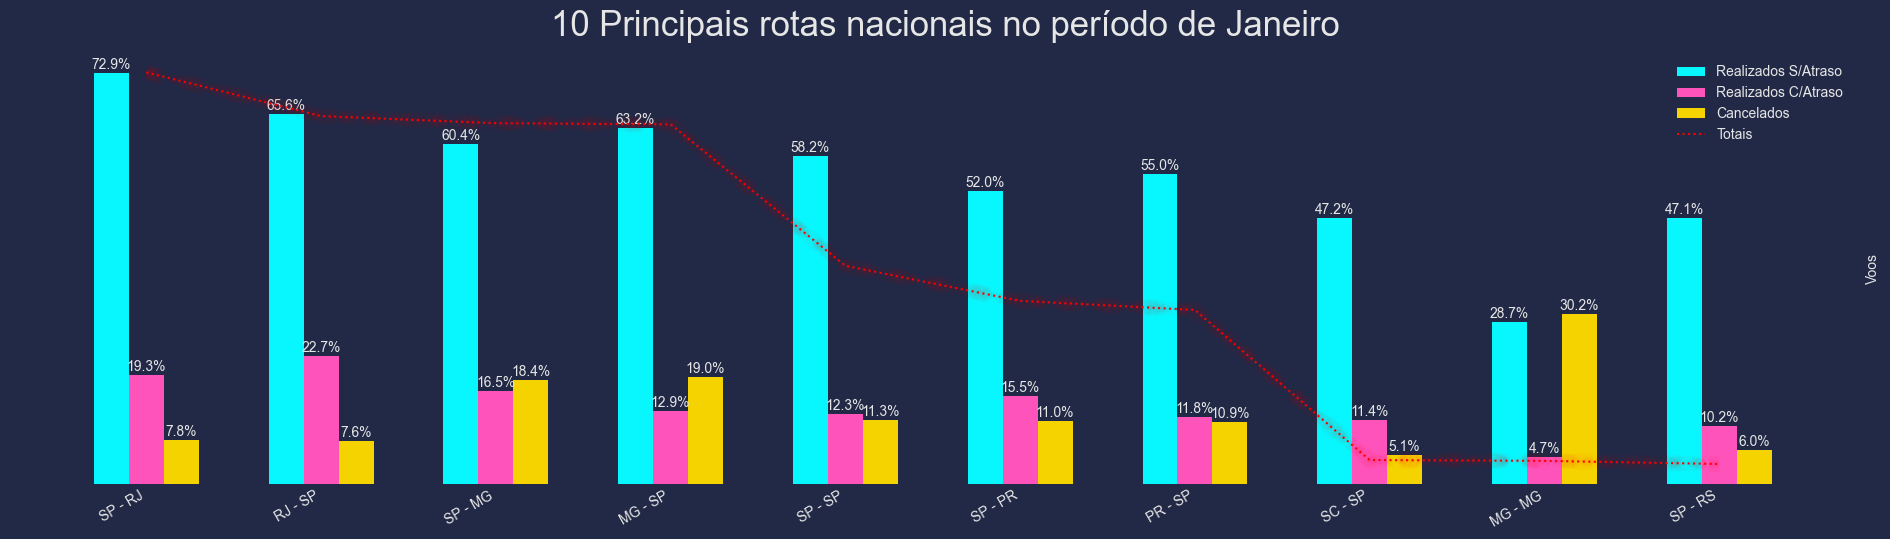

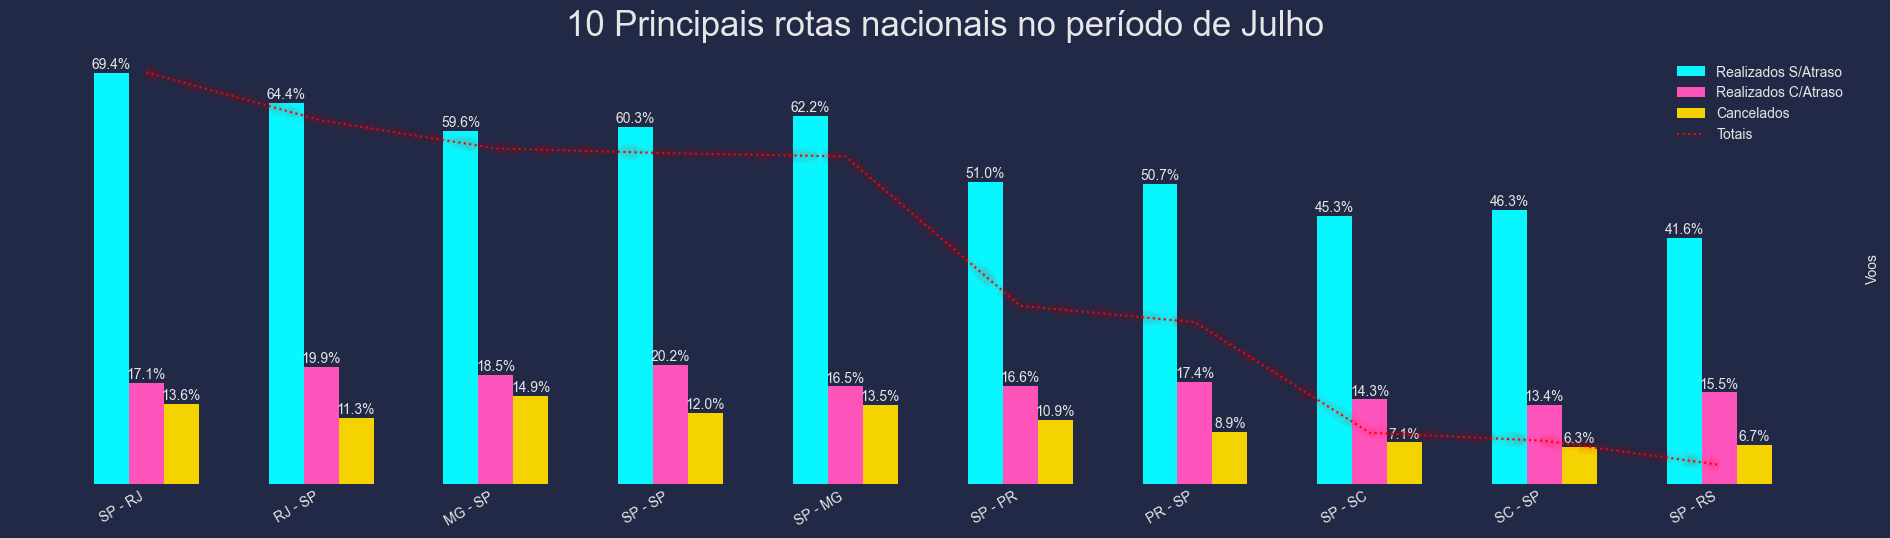

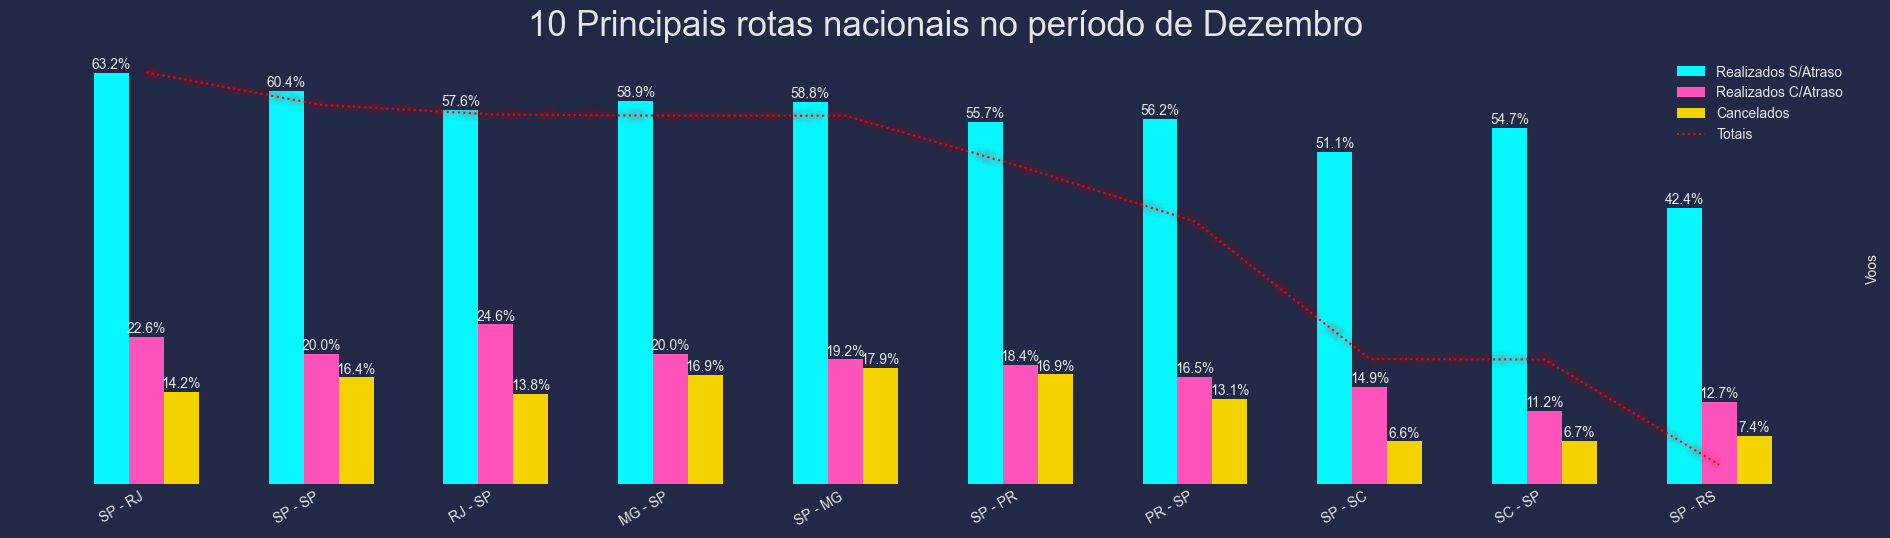

In [25]:
# Plot
for periodo in AnacVoos.periodo_ferias():
    Plot.periodo_ferias_tipo_linha(
        dataframe=nacionais.query("periodo_ferias == @periodo"),
        periodo_ferias=periodo,
        grid=False,
        context='cyberpunk',
        figsize=(19, 10),
        suptitle=f"10 Principais rotas nacionais no período de {periodo.title()}"
    )

### 3.1.2. Principais destinos internacionais nos períodos de julho, dezembro e janeiro

In [26]:
# Dataframe
internacionais = list()
linha = 'Internacional'

for i, periodo in enumerate(AnacVoos.periodo_ferias()):
    internacionais.append(
        AnacVoos.get_voos_ferias_linha_periodo(
            cols_percentuais=[
                ['tx_realizados', 'realizados_s_atraso'],
                ['tx_atrasos', 'realizados_c_atraso'],
                ['tx_cancelados', 'cancelados']],
            cols_groupyby=['codigo_tipo_linha', 'periodo_ferias', 'rota'],
            linha=linha, 
            periodo=periodo,
            round=3
            )
        )
    print(f"10 Principais rotas internacionais no período de {periodo.title()}")
    display(internacionais[i])
    print()

internacionais: pd.DataFrame = pd.concat(internacionais)

10 Principais rotas internacionais no período de Janeiro


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Internacional,janeiro,Estados Unidos - Brasil,7090.574461,1303,940,0.721,327,0.251,36,0.028
1,Internacional,janeiro,Brasil - Estados Unidos,7099.802539,1302,1081,0.830,196,0.151,25,0.019
2,Internacional,janeiro,Argentina - Brasil,1741.154345,1211,1108,0.915,81,0.067,22,0.018
3,Internacional,janeiro,Brasil - Argentina,1740.135592,1201,1063,0.885,116,0.097,22,0.018
4,Internacional,janeiro,Brasil - Panama,4874.583625,406,397,0.978,9,0.022,0,0.000
5,Internacional,janeiro,Panama - Brasil,4874.583625,406,385,0.948,15,0.037,6,0.015
6,Internacional,janeiro,Chile - Brasil,2758.119466,381,335,0.879,37,0.097,9,0.024
7,Internacional,janeiro,Brasil - Chile,2724.735142,371,306,0.825,64,0.173,1,0.003
8,Internacional,janeiro,Brasil - Portugal,7048.393230,321,264,0.822,55,0.171,2,0.006
9,Internacional,janeiro,Portugal - Brasil,7129.754497,310,241,0.777,66,0.213,3,0.010



10 Principais rotas internacionais no período de Julho


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Internacional,julho,Estados Unidos - Brasil,7040.629260,1274,820,0.644,421,0.330,33,0.026
1,Internacional,julho,Brasil - Estados Unidos,7045.472000,1262,965,0.765,241,0.191,56,0.044
2,Internacional,julho,Brasil - Argentina,1816.740174,1223,919,0.751,214,0.175,90,0.074
3,Internacional,julho,Argentina - Brasil,1816.898332,1221,910,0.745,224,0.183,87,0.071
4,Internacional,julho,Brasil - Chile,2698.101675,426,366,0.859,59,0.138,1,0.002
5,Internacional,julho,Chile - Brasil,2698.298077,425,362,0.852,63,0.148,0,0.000
6,Internacional,julho,Brasil - Panama,4859.593208,394,363,0.921,17,0.043,14,0.036
7,Internacional,julho,Panama - Brasil,4861.769865,394,344,0.873,32,0.081,18,0.046
8,Internacional,julho,Brasil - Portugal,7158.423843,327,251,0.768,72,0.220,4,0.012
9,Internacional,julho,Portugal - Brasil,7197.108557,327,252,0.771,71,0.217,4,0.012



10 Principais rotas internacionais no período de Dezembro


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Internacional,dezembro,Estados Unidos - Brasil,6994.696597,1229,842,0.685,329,0.268,58,0.047
1,Internacional,dezembro,Brasil - Estados Unidos,7009.009344,1222,1004,0.822,171,0.140,47,0.038
2,Internacional,dezembro,Brasil - Argentina,1798.812257,1127,884,0.784,193,0.171,50,0.044
3,Internacional,dezembro,Argentina - Brasil,1798.216187,1125,922,0.820,148,0.132,55,0.049
4,Internacional,dezembro,Brasil - Chile,2696.271628,430,368,0.856,54,0.126,8,0.019
5,Internacional,dezembro,Chile - Brasil,2696.963148,428,346,0.808,76,0.178,6,0.014
6,Internacional,dezembro,Brasil - Panama,4847.905193,370,353,0.954,9,0.024,8,0.022
7,Internacional,dezembro,Panama - Brasil,4847.905193,370,347,0.938,15,0.041,8,0.022
8,Internacional,dezembro,Brasil - Portugal,7050.567253,305,249,0.816,33,0.108,23,0.075
9,Internacional,dezembro,Portugal - Brasil,7092.521985,305,229,0.751,44,0.144,32,0.105


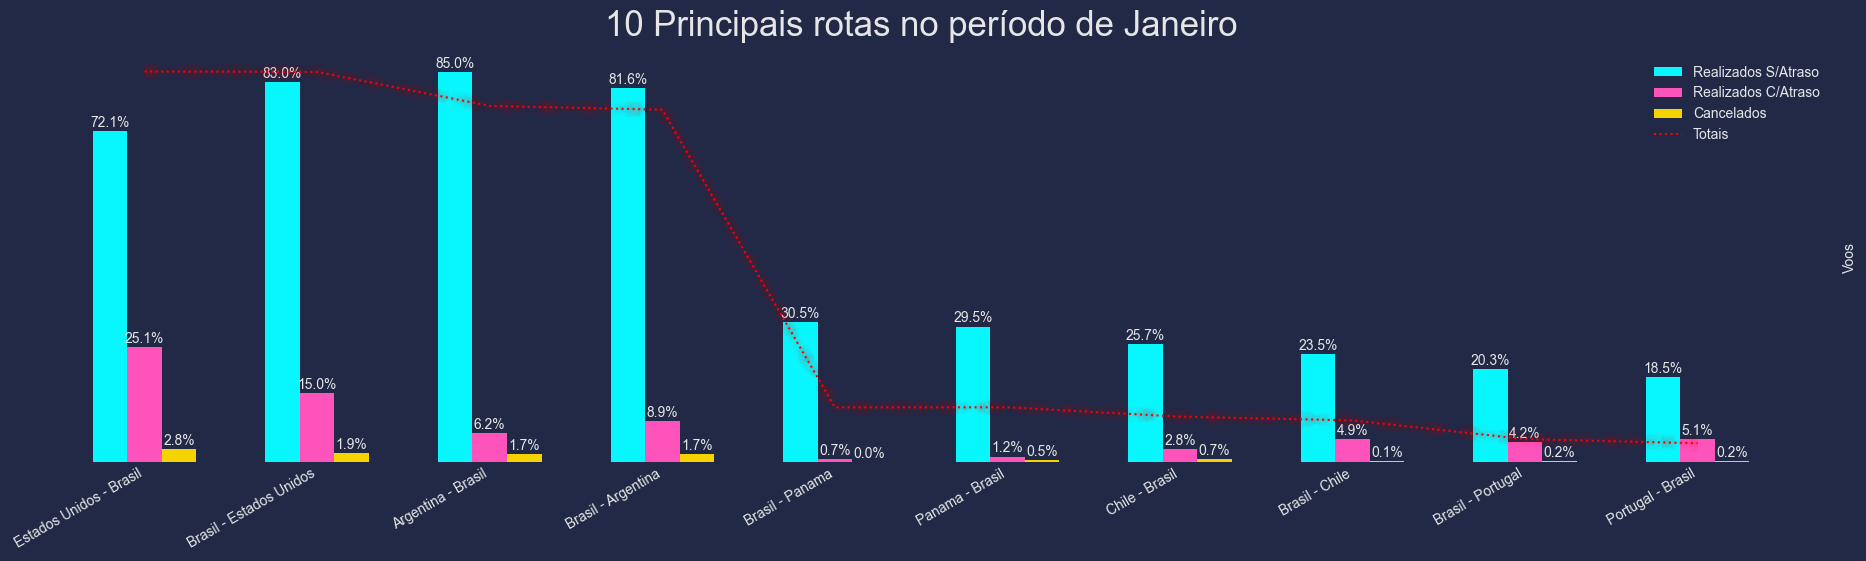

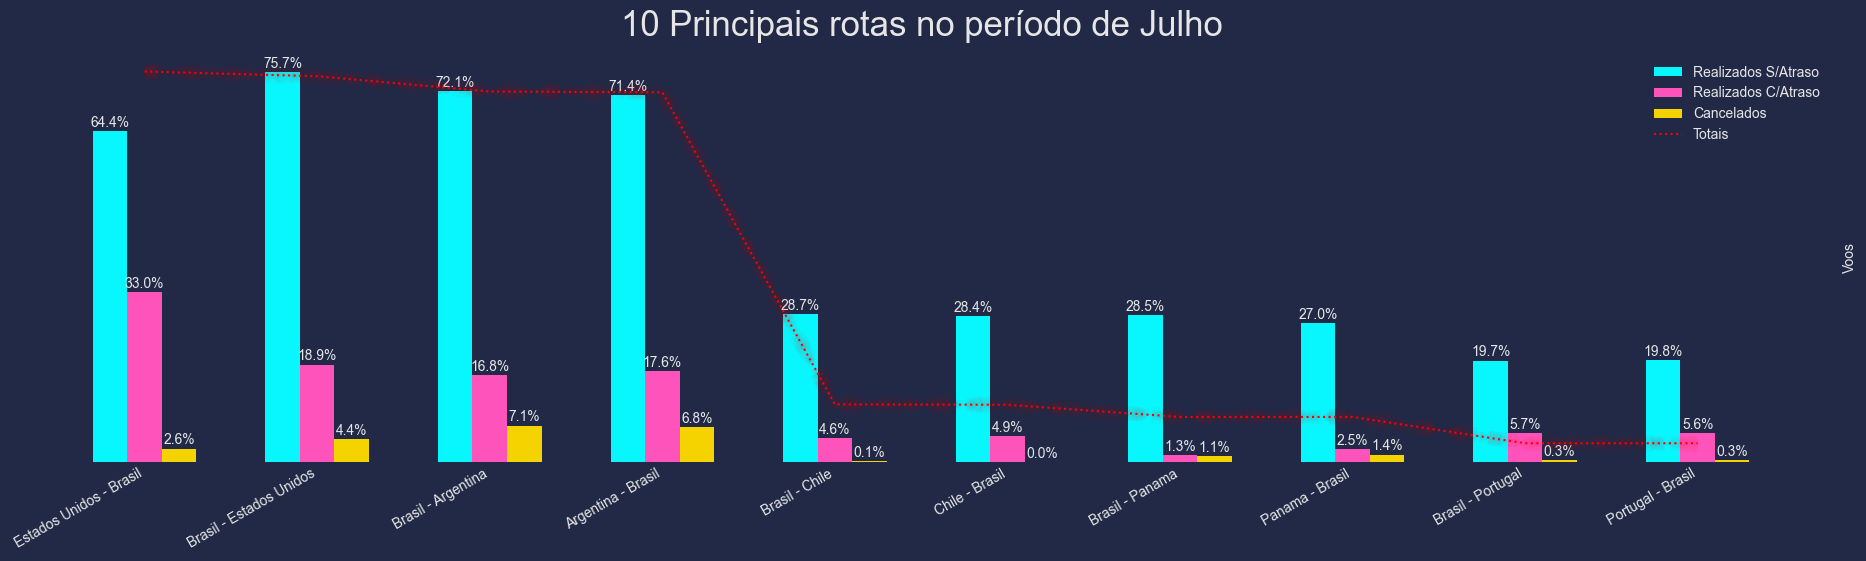

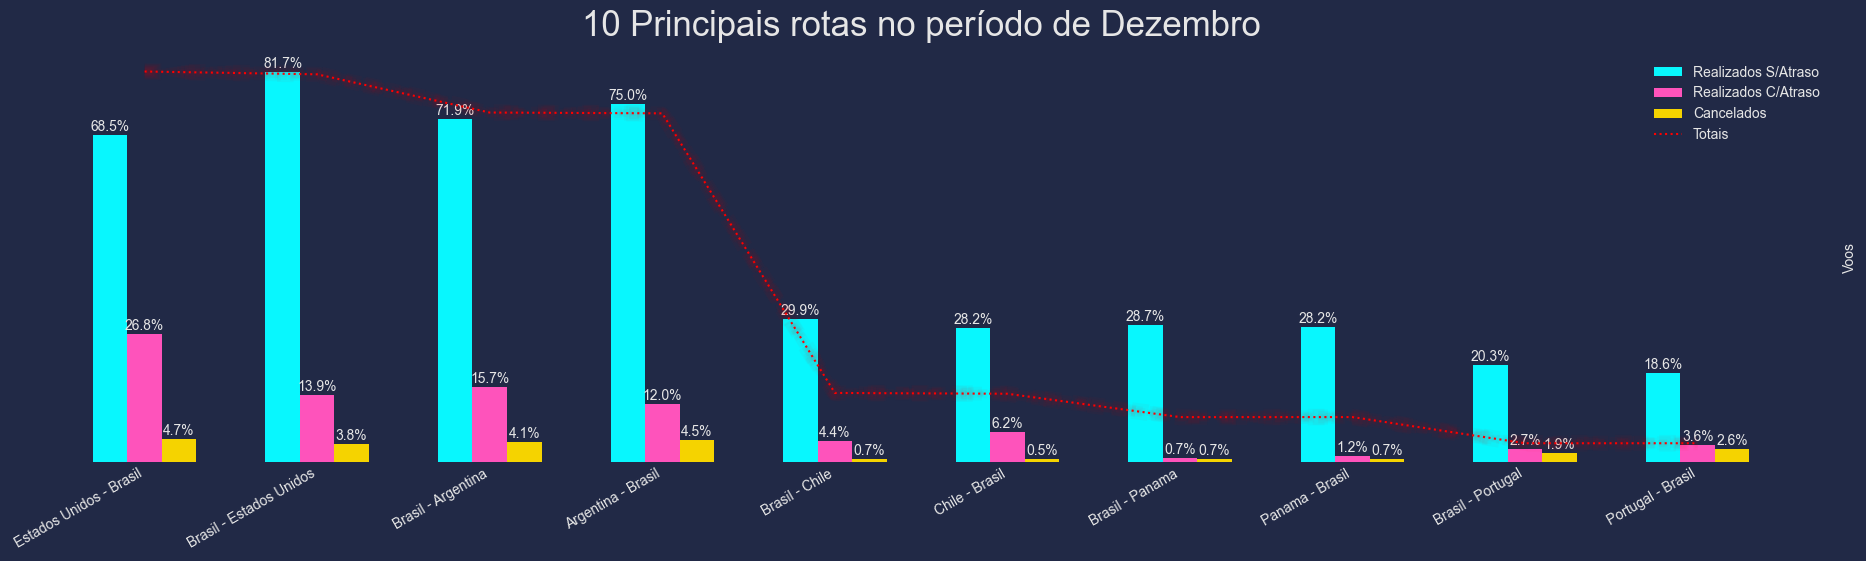

In [27]:
# Plot
for periodo in AnacVoos.periodo_ferias():
    Plot.periodo_ferias_tipo_linha(
        dataframe=internacionais.query("periodo_ferias == @periodo"),
        periodo_ferias=periodo,
        grid=False,
        context='cyberpunk',
        figsize=(19, 10),
        suptitle=f"10 Principais rotas no período de {periodo.title()}"
    )

## 3.2. Como ficam os aeroportos nesses meses?
Iremos analisar o aumento de atrasos, vôos cancelados, e os principais motivos, o dia mais provável de ter algum problema com o voo.

### 3.2.1. Atrasos

In [28]:
#Dataframe
total_voos, atrasos = AnacVoos.get_atrasos_voos_ferias(
                cols_groupby=['periodo_ferias', 'codigo_tipo_linha', 'justificativa_atraso'],
                converter_segundos_para_tempo=True,
            )

justificativas = atrasos.groupby('justificativa_atraso').agg(
    total_atrasos=('total_atrasos', 'sum'),
    tx_atrasos=('total_atrasos', lambda x: (x.sum() / total_voos).round(5))
).reset_index().sort_values(by='total_atrasos', ascending=False)

print(f"Total de atrasos para {total_voos} realizados nos períodos de férias:")
display(justificativas)

Total de atrasos para 277168 realizados nos períodos de férias:


,justificativa_atraso,total_atrasos,tx_atrasos
2,Atraso não especificado,24680,0.08904
10,Restrições operacionais no aeroporto,8631,0.03114
4,Conexão de aeronave,5543,0.02000
3,Condições meteorológicas,3833,0.01383
7,Interdição do aeroporto,3595,0.01297
5,Defeitos da aeronave,3498,0.01262
11,Troca de aeronave,1025,0.00370
8,Ordem técnica,520,0.00188
0,Alternativa abaixo dos limites,346,0.00125
9,Pane na aeronave,55,0.00020


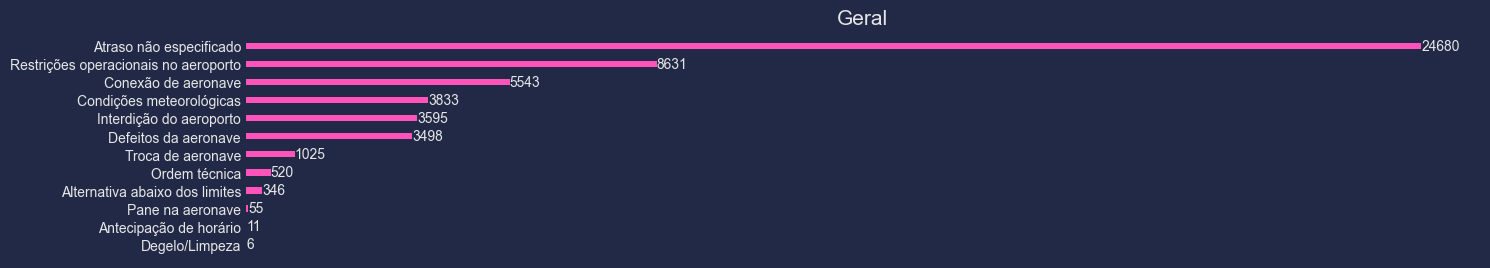

In [29]:
#Plot
Plot.atrasos_periodo_ferias(
            dataframe=justificativas, 
            periodo="Geral", 
            grid=False, 
            context='cyberpunk', 
            figsize=(15, 10))

#### 3.2.1.1 Atrasos em Janeiro

In [30]:
# Dataframe
periodo: str = 'janeiro'

for linha in AnacVoos.tipo_linha():
    print(f"Pincipais justificativas de cancelamento para voos realizados em {periodo.title()}:")
    display(atrasos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_atrasos'))
    print()

Pincipais justificativas de cancelamento para voos realizados em Janeiro:


,periodo_ferias,codigo_tipo_linha,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
32,janeiro,Nacional,Atraso não especificado,6475,00:37:54,00:41:13
37,janeiro,Nacional,Restrições operacionais no aeroporto,2101,00:27:42,00:27:43
34,janeiro,Nacional,Conexão de aeronave,1896,00:45:06,00:41:38
36,janeiro,Nacional,Interdição do aeroporto,1374,00:31:44,00:30:33
35,janeiro,Nacional,Defeitos da aeronave,1082,00:56:01,00:52:07
33,janeiro,Nacional,Condições meteorológicas,1075,00:55:14,00:52:34
38,janeiro,Nacional,Troca de aeronave,310,01:22:58,01:18:47
31,janeiro,Nacional,Alternativa abaixo dos limites,60,00:41:06,00:40:13



Pincipais justificativas de cancelamento para voos realizados em Janeiro:


,periodo_ferias,codigo_tipo_linha,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
22,janeiro,Internacional,Atraso não especificado,1186,01:29:30,01:44:08
25,janeiro,Internacional,Defeitos da aeronave,143,01:38:04,01:22:29
24,janeiro,Internacional,Conexão de aeronave,140,01:07:31,00:55:15
29,janeiro,Internacional,Restrições operacionais no aeroporto,131,00:54:28,00:46:33
23,janeiro,Internacional,Condições meteorológicas,61,00:55:32,00:56:37
30,janeiro,Internacional,Troca de aeronave,21,01:50:45,01:35:05
27,janeiro,Internacional,Interdição do aeroporto,14,00:47:17,00:38:08
28,janeiro,Internacional,Pane na aeronave,10,14:04:36,14:40:36
21,janeiro,Internacional,Alternativa abaixo dos limites,7,00:43:51,00:39:17
26,janeiro,Internacional,Degelo/Limpeza,3,00:43:40,01:28:20


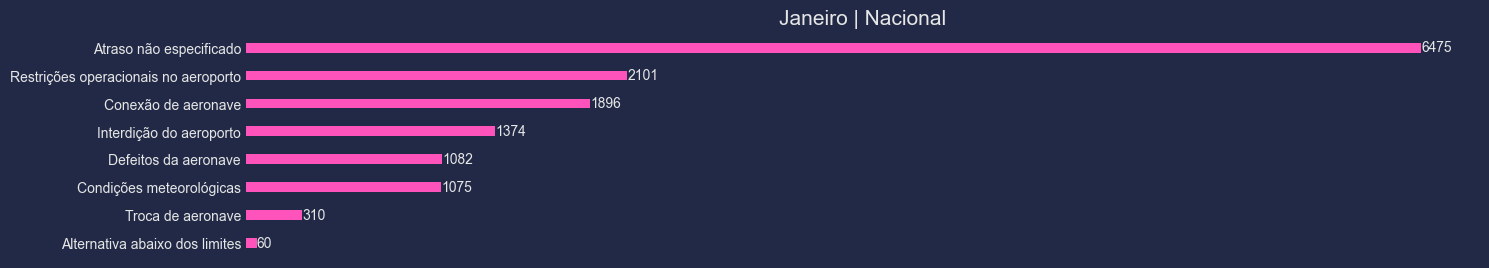

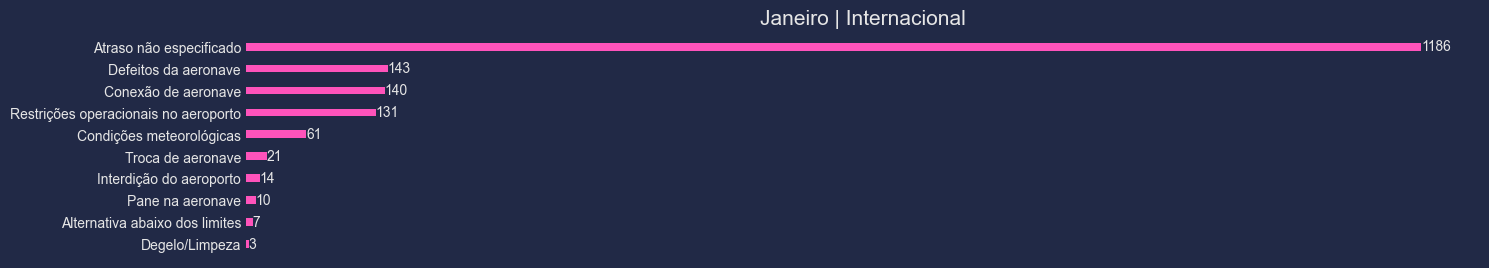

In [31]:
# Plot
for linha in AnacVoos.tipo_linha():
    Plot.atrasos_periodo_ferias(
                dataframe=atrasos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_atrasos'), 
                periodo=periodo,
                linha=linha, 
                grid=False, 
                context='cyberpunk', 
                figsize=(15, 10))

#### 3.2.1.2 Atrasos em Julho

In [32]:
# Dataframe
periodo: str = 'julho'

for linha in AnacVoos.tipo_linha():
    print(f"Pincipais justificativas de cancelamento para voos realizados em {periodo.title()}:")
    display(atrasos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_atrasos'))
    print()

Pincipais justificativas de cancelamento para voos realizados em Julho:


,periodo_ferias,codigo_tipo_linha,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
50,julho,Nacional,Atraso não especificado,7226,00:27:57,00:31:01
55,julho,Nacional,Restrições operacionais no aeroporto,3208,00:24:40,00:28:29
52,julho,Nacional,Conexão de aeronave,1520,00:36:28,00:35:38
51,julho,Nacional,Condições meteorológicas,1376,00:58:12,00:58:06
53,julho,Nacional,Defeitos da aeronave,1045,00:52:20,00:50:09
54,julho,Nacional,Interdição do aeroporto,781,00:26:38,00:26:13
56,julho,Nacional,Troca de aeronave,364,01:15:54,01:11:46
49,julho,Nacional,Alternativa abaixo dos limites,149,01:06:26,01:03:37



Pincipais justificativas de cancelamento para voos realizados em Julho:


,periodo_ferias,codigo_tipo_linha,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
41,julho,Internacional,Atraso não especificado,1413,01:05:38,01:14:05
47,julho,Internacional,Restrições operacionais no aeroporto,215,00:49:32,00:48:56
43,julho,Internacional,Conexão de aeronave,187,01:20:37,01:12:42
44,julho,Internacional,Defeitos da aeronave,184,02:16:48,02:27:28
42,julho,Internacional,Condições meteorológicas,73,00:53:21,00:54:45
48,julho,Internacional,Troca de aeronave,39,01:42:04,01:34:47
46,julho,Internacional,Pane na aeronave,20,11:57:51,11:54:21
39,julho,Internacional,Alternativa abaixo dos limites,17,01:57:03,01:50:38
45,julho,Internacional,Interdição do aeroporto,15,01:04:12,00:12:40
40,julho,Internacional,Antecipação de horário,9,00:29:26,00:04:13


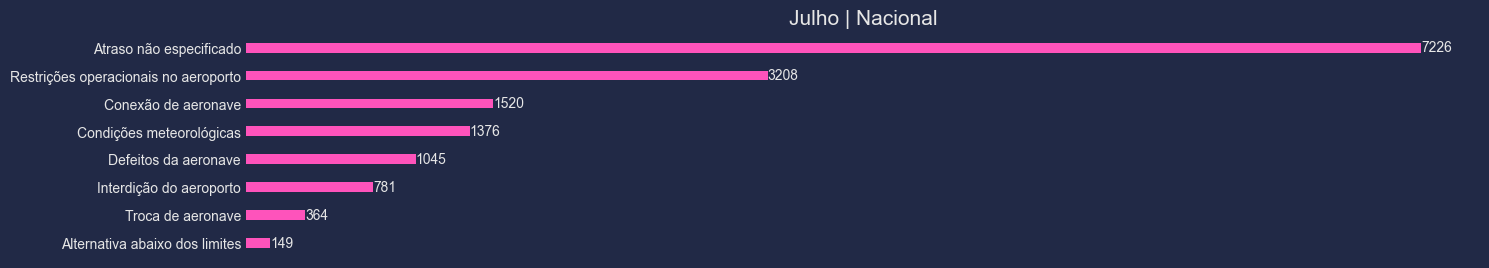

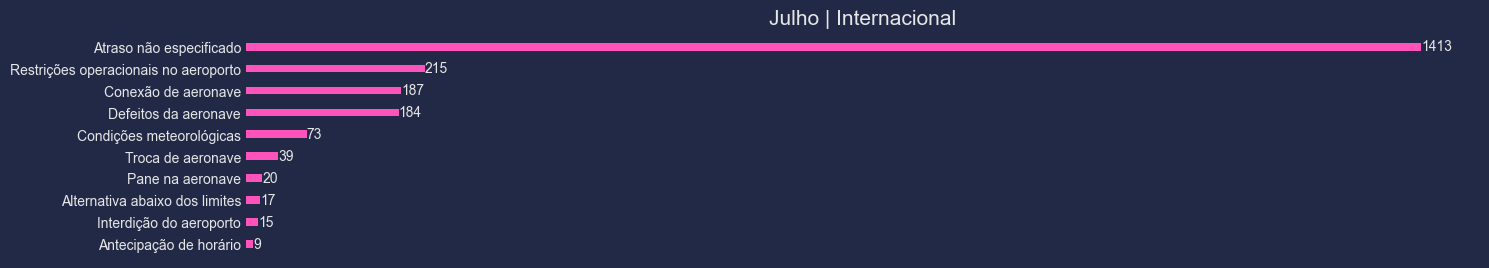

In [33]:
# Plot
for linha in AnacVoos.tipo_linha():
    Plot.atrasos_periodo_ferias(
                dataframe=atrasos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_atrasos'), 
                periodo=periodo,
                linha=linha, 
                grid=False, 
                context='cyberpunk', 
                figsize=(15, 10))

#### 3.2.1.3 Atrasos em Dezembro

In [34]:
# Dataframe
periodo: str = 'dezembro'

for linha in AnacVoos.tipo_linha():
    print(f"Pincipais justificativas de cancelamento para voos realizados em {periodo.title()}:")
    display(atrasos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_atrasos'))
    print()

Pincipais justificativas de cancelamento para voos realizados em Dezembro:


,periodo_ferias,codigo_tipo_linha,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
12,dezembro,Nacional,Atraso não especificado,7047,00:22:43,00:24:27
19,dezembro,Nacional,Restrições operacionais no aeroporto,2800,00:24:05,00:29:23
14,dezembro,Nacional,Conexão de aeronave,1640,00:38:52,00:41:33
17,dezembro,Nacional,Interdição do aeroporto,1394,00:31:55,00:31:36
13,dezembro,Nacional,Condições meteorológicas,1183,00:46:43,00:46:12
15,dezembro,Nacional,Defeitos da aeronave,904,00:52:25,00:50:39
18,dezembro,Nacional,Ordem técnica,497,00:29:22,00:34:07
20,dezembro,Nacional,Troca de aeronave,266,01:18:28,01:16:30
11,dezembro,Nacional,Alternativa abaixo dos limites,92,00:58:42,00:59:06
16,dezembro,Nacional,Degelo/Limpeza,3,00:13:40,00:54:40



Pincipais justificativas de cancelamento para voos realizados em Dezembro:


,periodo_ferias,codigo_tipo_linha,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
2,dezembro,Internacional,Atraso não especificado,1333,01:18:19,01:19:15
9,dezembro,Internacional,Restrições operacionais no aeroporto,176,00:46:54,00:44:21
4,dezembro,Internacional,Conexão de aeronave,160,01:39:05,01:22:27
5,dezembro,Internacional,Defeitos da aeronave,140,01:25:03,01:14:46
3,dezembro,Internacional,Condições meteorológicas,65,00:46:28,00:35:45
8,dezembro,Internacional,Pane na aeronave,25,11:39:40,11:24:07
10,dezembro,Internacional,Troca de aeronave,25,02:30:36,02:11:14
7,dezembro,Internacional,Ordem técnica,23,00:41:52,00:41:20
0,dezembro,Internacional,Alternativa abaixo dos limites,21,01:25:17,01:21:31
6,dezembro,Internacional,Interdição do aeroporto,17,01:07:42,00:46:38


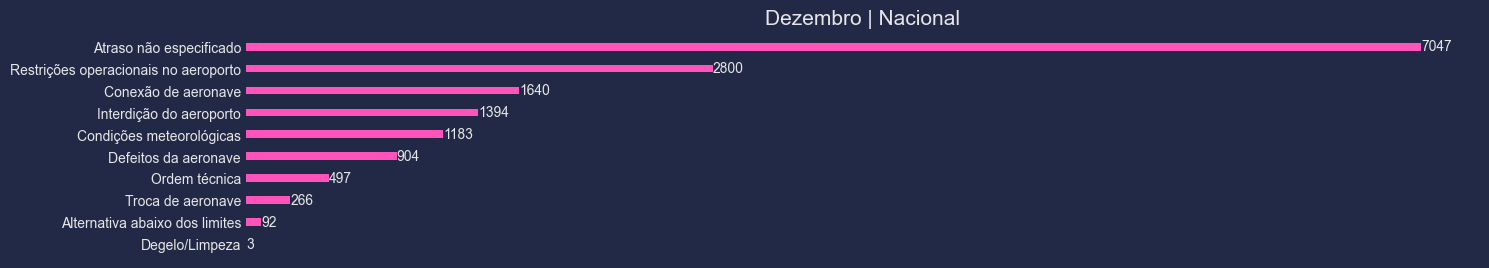

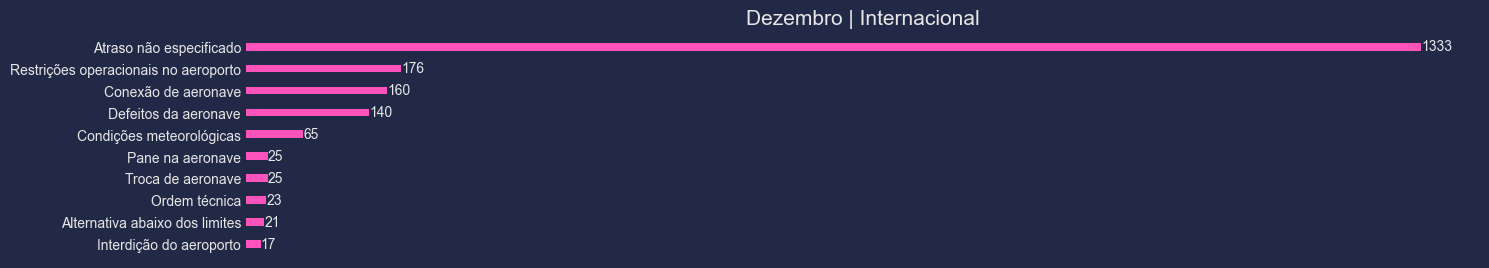

In [35]:
# Plot
for linha in AnacVoos.tipo_linha():
    Plot.atrasos_periodo_ferias(
                dataframe=atrasos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_atrasos'), 
                periodo=periodo,
                linha=linha, 
                grid=False, 
                context='cyberpunk', 
                figsize=(15, 10))

### 3.2.2. Cancelamentos

In [36]:
# Dataframe
cancelamentos = list()

for i, periodo in enumerate(AnacVoos.periodo_ferias()):
    for linha in AnacVoos.tipo_linha():
        t, c = AnacVoos.get_cancelamentos_voos_ferias(
            cols_groupby=['periodo_ferias', 'codigo_tipo_linha', 'justificativa_cancelamento'],
            col_tx='tx_cancelamentos',
            round=3,
            periodo=periodo,
            linha=linha
        )
        cancelamentos.append([t, c])

total_voos = [cancelamento[0] for cancelamento in cancelamentos]
cancelamentos: pd.DataFrame = pd.concat([cancelamento[1] for cancelamento in cancelamentos])

justificativas = cancelamentos.groupby('justificativa_cancelamento').agg(
    total_cancelamentos=('total_cancelamentos', 'sum'),
    tx_cancelamentos=('total_cancelamentos', lambda x: (x.sum() / sum(total_voos)).round(4))
).reset_index().sort_values(by='total_cancelamentos', ascending=False)

print(f"Total de cancelamentos para {sum(total_voos)} realizados nos períodos de férias:")
display(justificativas)

Total de cancelamentos para 277168 realizados nos períodos de férias:


,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
5,Motivos técnicos-operacionais,18179,0.0656
0,Cancelamento não especificado,10767,0.0388
2,Falta de passageiros com passagem marcada,1322,0.0048
3,Feriado nacional,645,0.0023
1,Condições meteorológicas,313,0.0011
4,Interdição do aeroporto,52,0.0002


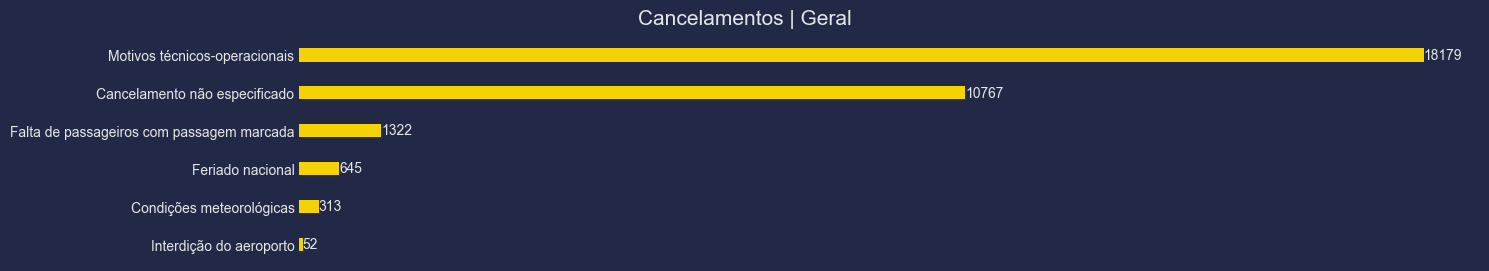

In [37]:
#Plot
Plot.justificativas_cancelamento(
    dataframe=justificativas,
    grid=False,
    context='cyberpunk',
    figsize=(15, 10),
    add_suptitle="Geral"
    )

#### 3.2.2.1 Cancelamentos em Janeiro

In [38]:
# Dataframe
periodo: str = 'janeiro'

for linha in AnacVoos.tipo_linha():
    print(f"Pincipais justificativas de cancelamento para voos realizados em {periodo.title()}:")
    display(cancelamentos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_cancelamentos'))
    print()

Pincipais justificativas de cancelamento para voos realizados em Janeiro:


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
5,janeiro,Nacional,Motivos técnicos-operacionais,7810,0.096
0,janeiro,Nacional,Cancelamento não especificado,614,0.008
3,janeiro,Nacional,Feriado nacional,378,0.005
2,janeiro,Nacional,Falta de passageiros com passagem marcada,266,0.003
1,janeiro,Nacional,Condições meteorológicas,59,0.001
4,janeiro,Nacional,Interdição do aeroporto,22,0.000



Pincipais justificativas de cancelamento para voos realizados em Janeiro:


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
3,janeiro,Internacional,Motivos técnicos-operacionais,186,0.016
0,janeiro,Internacional,Cancelamento não especificado,34,0.003
1,janeiro,Internacional,Feriado nacional,7,0.001
2,janeiro,Internacional,Interdição do aeroporto,1,0.000


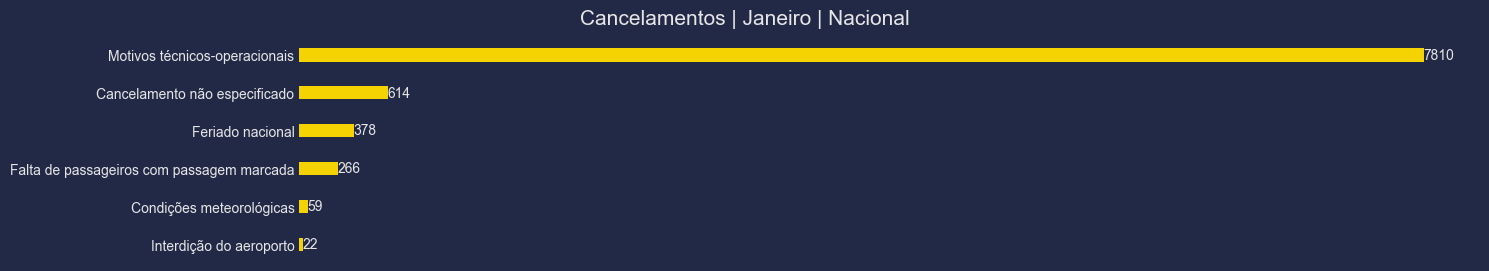

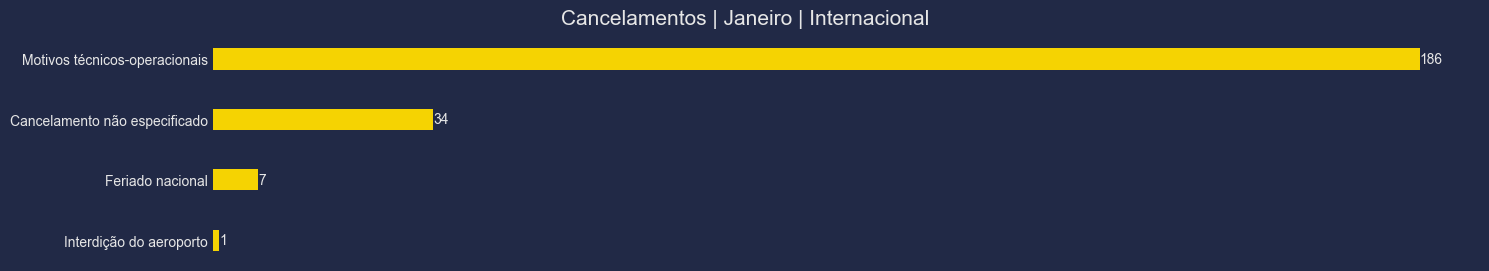

In [39]:
#Plot
for linha in AnacVoos.tipo_linha():
    Plot.justificativas_cancelamento(
        dataframe=cancelamentos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_cancelamentos'),
        grid=False,
        context='cyberpunk',
        figsize=(15, 10),
        add_suptitle=periodo
        )

#### 3.2.2.2 Cancelamentos em Julho

In [40]:
# Dataframe
periodo: str = 'julho'

for linha in AnacVoos.tipo_linha():
    print(f"Pincipais justificativas de cancelamento para voos realizados em {periodo.title()}:")
    display(cancelamentos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_cancelamentos'))
    print()

Pincipais justificativas de cancelamento para voos realizados em Julho:


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
5,julho,Nacional,Motivos técnicos-operacionais,5196,0.064
0,julho,Nacional,Cancelamento não especificado,4003,0.050
2,julho,Nacional,Falta de passageiros com passagem marcada,377,0.005
1,julho,Nacional,Condições meteorológicas,142,0.002
3,julho,Nacional,Feriado nacional,24,0.000
4,julho,Nacional,Interdição do aeroporto,9,0.000



Pincipais justificativas de cancelamento para voos realizados em Julho:


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
3,julho,Internacional,Motivos técnicos-operacionais,427,0.038
0,julho,Internacional,Cancelamento não especificado,84,0.007
1,julho,Internacional,Feriado nacional,44,0.004
2,julho,Internacional,Interdição do aeroporto,1,0.000


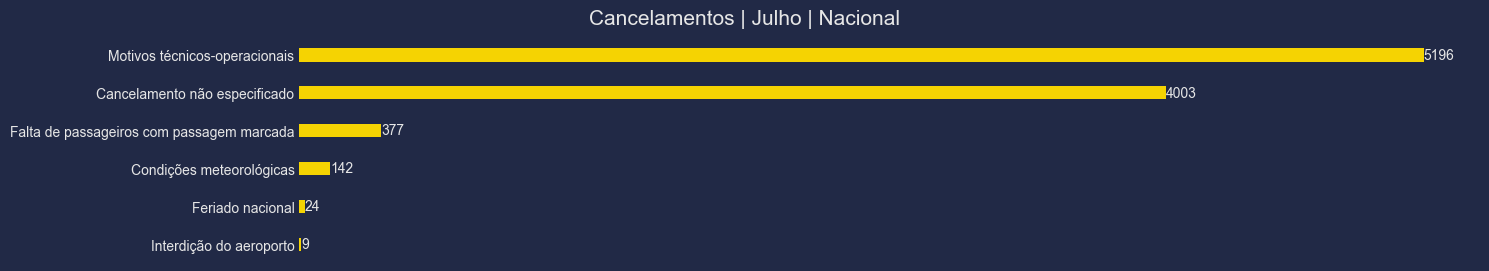

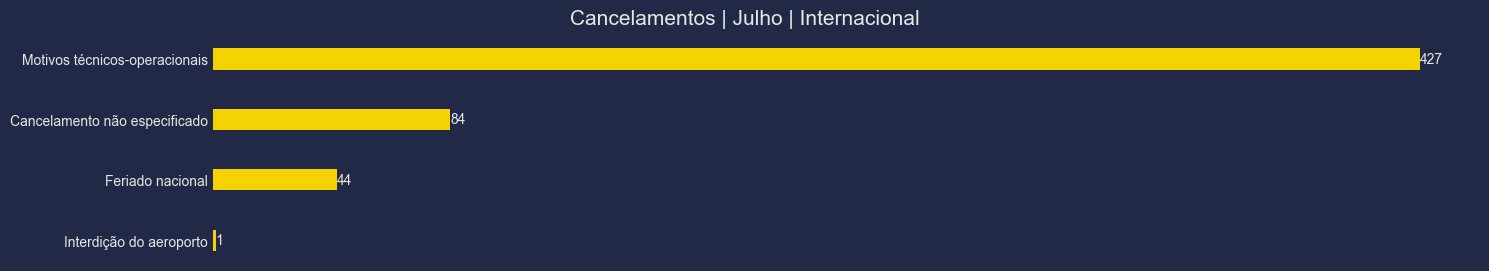

In [41]:
#Plot
for linha in AnacVoos.tipo_linha():
    Plot.justificativas_cancelamento(
        dataframe=cancelamentos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo'),
        grid=False,
        context='cyberpunk',
        figsize=(15, 10),
        add_suptitle=periodo
        )

#### 3.2.2.3 Cancelamentos em Dezembro

In [42]:
# Dataframe
periodo: str = 'dezembro'

for linha in AnacVoos.tipo_linha():
    print(f"Pincipais justificativas de cancelamento para voos realizados em {periodo.title()}:")
    display(cancelamentos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_cancelamentos'))
    print()

Pincipais justificativas de cancelamento para voos realizados em Dezembro:


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
0,dezembro,Nacional,Cancelamento não especificado,5739,0.071
5,dezembro,Nacional,Motivos técnicos-operacionais,4323,0.053
2,dezembro,Nacional,Falta de passageiros com passagem marcada,679,0.008
3,dezembro,Nacional,Feriado nacional,191,0.002
1,dezembro,Nacional,Condições meteorológicas,110,0.001
4,dezembro,Nacional,Interdição do aeroporto,15,0.000



Pincipais justificativas de cancelamento para voos realizados em Dezembro:


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
0,dezembro,Internacional,Cancelamento não especificado,293,0.026
4,dezembro,Internacional,Motivos técnicos-operacionais,237,0.021
3,dezembro,Internacional,Interdição do aeroporto,4,0.000
1,dezembro,Internacional,Condições meteorológicas,2,0.000
2,dezembro,Internacional,Feriado nacional,1,0.000


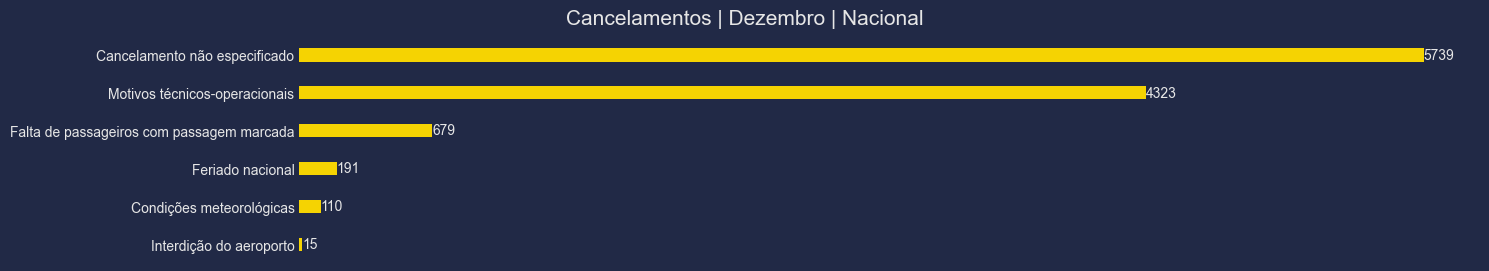

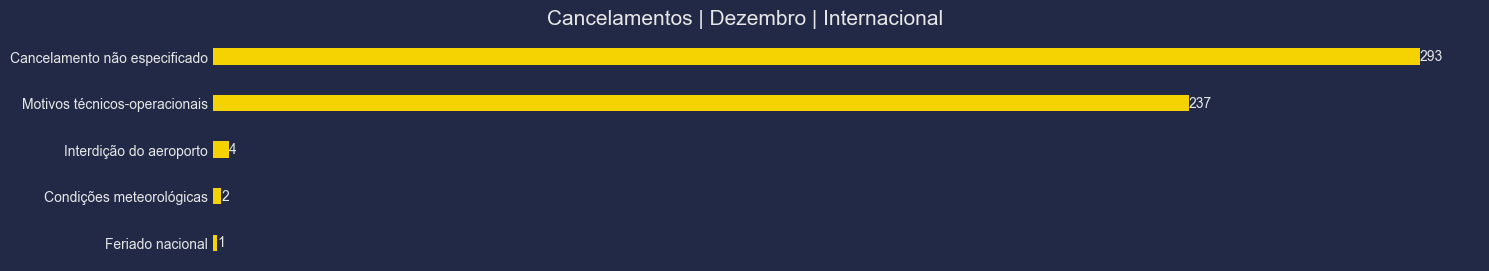

In [43]:
#Plot
for linha in AnacVoos.tipo_linha():
    Plot.justificativas_cancelamento(
        dataframe=cancelamentos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo'),
        grid=False,
        context='cyberpunk',
        figsize=(15, 10),
        add_suptitle=periodo
        )

## 3.3. Qual a melhor opção uma viagem nacional ou internacional?
Após as análises da questão 02, vamos analisar se existe algum favorecimento de vôos internacionais sobre os nacionais.

In [44]:
#Dataframe
resumo: pd.DataFrame = AnacVoos.get_voos_ferias_resumo(
    cols_groupby = ['codigo_tipo_linha', 'periodo_ferias'],
    col_tx = [
        ['tx_realizados', 'realizados_s_atraso'],
        ['tx_atrasos', 'realizados_c_atraso'],
        ['tx_cancelados', 'cancelados']
    ],
    round=3
)

for linha in AnacVoos.tipo_linha():
    display(resumo.query("codigo_tipo_linha == @linha"))


,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,janeiro,81597,58075,0.712,14373,0.176,9149,0.112
1,Nacional,dezembro,80996,54113,0.668,15826,0.195,11057,0.137
2,Nacional,julho,80587,55167,0.685,15669,0.194,9751,0.121


,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
3,Internacional,janeiro,11484,9540,0.831,1716,0.149,228,0.020
4,Internacional,julho,11379,8651,0.760,2172,0.191,556,0.049
5,Internacional,dezembro,11125,8601,0.773,1987,0.179,537,0.048


## 3.4. Qual a melhor rota?
Aqui faremos o DE-PARA entre os  aeroporto origem/destino, para os principais destinos, levantados na pergunta 01.

In [45]:
# Dataframe Internacional
voos_ferias = AnacVoos.get_voos_ferias()

internacionais = voos_ferias[voos_ferias['codigo_tipo_linha'] == 'Internacional']\
    .groupby(['periodo_ferias', 'rota']).size()\
    .reset_index(name='voos')

nacionais = voos_ferias[voos_ferias['codigo_tipo_linha'] == 'Nacional']\
    .groupby(['periodo_ferias', 'rota']).size()\
    .reset_index(name='voos')

for periodo in AnacVoos.periodo_ferias():
    internacionais_periodo = internacionais.query("periodo_ferias == @periodo")
    nacionais_periodo = nacionais.query("periodo_ferias == @periodo")

    top_internacionais = internacionais_periodo.nlargest(1, 'voos')
    top_nacionais = nacionais_periodo.nlargest(1, 'voos')

    print(f"Comparando os destinos mais procurados no período de {periodo}:")

    if not top_internacionais.empty and not top_nacionais.empty:
        if top_internacionais['voos'].values[0] > top_nacionais['voos'].values[0]:
            print(
                "O destino internacional mais procurado supera o destino nacional mais procurado.")
        elif top_internacionais['voos'].values[0] < top_nacionais['voos'].values[0]:
            print(
                "O destino nacional mais procurado supera o destino internacional mais procurado.")
        else:
            print(
                "O destino internacional e o destino nacional mais procurados têm a mesma quantidade de voos.")

        print("Destino internacional mais procurado:")
        display(top_internacionais.reset_index(drop=True))

        print("Destino nacional mais procurado:")
        display(top_nacionais.reset_index(drop=True))
    elif not top_internacionais.empty:
        print("Não foram encontrados destinos nacionais mais procurados neste período.")

        print("Destino internacional mais procurado:")
        display(top_internacionais.reset_index(drop=True))
    elif not top_nacionais.empty:
        print(
            "Não foram encontrados destinos internacionais mais procurados neste período.")

        print("Destino nacional mais procurado:")
        display(top_nacionais.reset_index(drop=True))
    else:
        print("Não foram encontrados destinos internacionais nem nacionais mais procurados neste período.")

    print()

Comparando os destinos mais procurados no período de janeiro:
O destino nacional mais procurado supera o destino internacional mais procurado.
Destino internacional mais procurado:


,periodo_ferias,rota,voos
0,janeiro,Estados Unidos - Brasil,1303


Destino nacional mais procurado:


,periodo_ferias,rota,voos
0,janeiro,SP - RJ,2707



Comparando os destinos mais procurados no período de julho:
O destino nacional mais procurado supera o destino internacional mais procurado.
Destino internacional mais procurado:


,periodo_ferias,rota,voos
0,julho,Estados Unidos - Brasil,1274


Destino nacional mais procurado:


,periodo_ferias,rota,voos
0,julho,SP - RJ,2708



Comparando os destinos mais procurados no período de dezembro:
O destino nacional mais procurado supera o destino internacional mais procurado.
Destino internacional mais procurado:


,periodo_ferias,rota,voos
0,dezembro,Estados Unidos - Brasil,1229


Destino nacional mais procurado:


,periodo_ferias,rota,voos
0,dezembro,SP - RJ,2609


## 3.5. Qual melhor dia da semana para pegar um vôo?
Iremos cruzar as informações de cancelamentos e atrasados com os dias da semana e verificar qual o dia tem uma menor probabilidade de ter algum problema.

In [46]:
semanas: pd.DataFrame = AnacVoos.get_voos_ferias_resumo(
    cols_groupby=['codigo_tipo_linha', 'periodo_ferias', 'dia_semana'],
    col_tx=[
        ['tx_realizados', 'realizados_s_atraso'],
        ['tx_atrasos', 'realizados_c_atraso'],
        ['tx_cancelados', 'cancelados']],
    round=2,
    ordenar_resumo=True
)

ordem_codigo_tipo_linha = ['Nacional', 'Internacional']
ordem_periodo_ferias = ['janeiro', 'julho', 'dezembro']
ordem_dia_semana = ['domingo', 'segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira', 'sábado']

semanas['codigo_tipo_linha'] = pd.Categorical(semanas['codigo_tipo_linha'], categories=ordem_codigo_tipo_linha, ordered=True)
semanas['periodo_ferias'] = pd.Categorical(semanas['periodo_ferias'], categories=ordem_periodo_ferias, ordered=True)
semanas['dia_semana'] = pd.Categorical(semanas['dia_semana'], categories=ordem_dia_semana, ordered=True)

semanas = semanas.sort_values(by=['codigo_tipo_linha', 'periodo_ferias', 'dia_semana'])

display(semanas)

,codigo_tipo_linha,periodo_ferias,dia_semana,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
16,Nacional,janeiro,domingo,9358,6857,0.73,1626,0.17,875,0.09
8,Nacional,janeiro,segunda-feira,11204,7825,0.70,2256,0.20,1123,0.10
13,Nacional,janeiro,terça-feira,11050,8082,0.73,1704,0.15,1264,0.11
11,Nacional,janeiro,quarta-feira,11069,7832,0.71,2087,0.19,1150,0.10
1,Nacional,janeiro,quinta-feira,13897,9012,0.65,2881,0.21,2004,0.14
0,Nacional,janeiro,sexta-feira,14013,10167,0.73,2267,0.16,1579,0.11
14,Nacional,janeiro,sábado,11006,8300,0.75,1552,0.14,1154,0.10
17,Nacional,julho,domingo,9236,6807,0.74,1431,0.15,998,0.11
12,Nacional,julho,segunda-feira,11063,7972,0.72,1893,0.17,1198,0.11
15,Nacional,julho,terça-feira,10806,7234,0.67,2192,0.20,1380,0.13


In [47]:
# Dataframe
atrasos = voos_ferias\
    .query("partida_atrasou == 'N' and chegada_atrasou == 'N' and situacao_voo != 'Cancelado'")\
    .groupby(['codigo_tipo_linha', 'periodo_ferias', 'rota', 'aeroporto_origem', 'aeroporto_destino', 'dia_semana'])\
    .size().reset_index(name='qtd_atraso')\
    .sort_values('qtd_atraso', ascending=False)

for periodo in AnacVoos.periodo_ferias():
    for linha in AnacVoos.tipo_linha():
        print(f"\n\nVoo {linha} em {periodo.title()}:")
        display(atrasos.query("periodo_ferias == @periodo and codigo_tipo_linha == @linha").head(10).reset_index(drop=True))

# Atualizando tempo do processo
AnacVoos.tempo_execucao = (time.time() - AnacVoos.tempo_execucao)



Voo Nacional em Janeiro:


,codigo_tipo_linha,periodo_ferias,rota,aeroporto_origem,aeroporto_destino,dia_semana,qtd_atraso
0,Nacional,janeiro,BA - SP,Deputado Luis Eduardo Magalhaes,Guarulhos - Governador Andre Franco Montoro,sexta-feira,105
1,Nacional,janeiro,MG - SP,Tancredo Neves,Congonhas,sexta-feira,99
2,Nacional,janeiro,SP - BA,Guarulhos - Governador Andre Franco Montoro,Deputado Luis Eduardo Magalhaes,sábado,99
3,Nacional,janeiro,SP - BA,Guarulhos - Governador Andre Franco Montoro,Deputado Luis Eduardo Magalhaes,sexta-feira,98
4,Nacional,janeiro,SP - MG,Congonhas,Tancredo Neves,sexta-feira,98
5,Nacional,janeiro,SP - RS,Guarulhos - Governador Andre Franco Montoro,Salgado Filho,sábado,93
6,Nacional,janeiro,RS - SP,Salgado Filho,Guarulhos - Governador Andre Franco Montoro,sexta-feira,90
7,Nacional,janeiro,RJ - DF,Santos Dumont,Presidente Juscelino Kubitschek,sexta-feira,90
8,Nacional,janeiro,DF - RJ,Presidente Juscelino Kubitschek,Santos Dumont,sexta-feira,90
9,Nacional,janeiro,SP - RS,Guarulhos - Governador Andre Franco Montoro,Salgado Filho,sexta-feira,89




Voo Internacional em Janeiro:


,codigo_tipo_linha,periodo_ferias,rota,aeroporto_origem,aeroporto_destino,dia_semana,qtd_atraso
0,Internacional,janeiro,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,sábado,45
1,Internacional,janeiro,Argentina - Brasil,Buenos Aires/Aeroparque,Guarulhos - Governador Andre Franco Montoro,sábado,44
2,Internacional,janeiro,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,sexta-feira,43
3,Internacional,janeiro,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,quinta-feira,43
4,Internacional,janeiro,Argentina - Brasil,Buenos Aires/Aeroparque,Guarulhos - Governador Andre Franco Montoro,quinta-feira,43
5,Internacional,janeiro,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,quinta-feira,42
6,Internacional,janeiro,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,sexta-feira,42
7,Internacional,janeiro,Argentina - Brasil,Buenos Aires/Aeroparque,Guarulhos - Governador Andre Franco Montoro,sexta-feira,40
8,Internacional,janeiro,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,domingo,38
9,Internacional,janeiro,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,sábado,38




Voo Nacional em Julho:


,codigo_tipo_linha,periodo_ferias,rota,aeroporto_origem,aeroporto_destino,dia_semana,qtd_atraso
0,Nacional,julho,SP - MG,Congonhas,Tancredo Neves,quarta-feira,116
1,Nacional,julho,MG - SP,Tancredo Neves,Congonhas,quarta-feira,110
2,Nacional,julho,SP - MG,Congonhas,Tancredo Neves,sexta-feira,97
3,Nacional,julho,SP - MG,Congonhas,Tancredo Neves,quinta-feira,96
4,Nacional,julho,SP - MG,Congonhas,Tancredo Neves,segunda-feira,93
5,Nacional,julho,BA - SP,Deputado Luis Eduardo Magalhaes,Guarulhos - Governador Andre Franco Montoro,sexta-feira,91
6,Nacional,julho,MG - SP,Tancredo Neves,Congonhas,sexta-feira,87
7,Nacional,julho,MG - SP,Tancredo Neves,Congonhas,quinta-feira,85
8,Nacional,julho,RS - SP,Salgado Filho,Guarulhos - Governador Andre Franco Montoro,quinta-feira,83
9,Nacional,julho,RS - SP,Salgado Filho,Guarulhos - Governador Andre Franco Montoro,quarta-feira,82




Voo Internacional em Julho:


,codigo_tipo_linha,periodo_ferias,rota,aeroporto_origem,aeroporto_destino,dia_semana,qtd_atraso
0,Internacional,julho,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,sexta-feira,48
1,Internacional,julho,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,sexta-feira,47
2,Internacional,julho,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,quinta-feira,46
3,Internacional,julho,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,quinta-feira,46
4,Internacional,julho,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,quinta-feira,45
5,Internacional,julho,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,quarta-feira,43
6,Internacional,julho,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,quarta-feira,43
7,Internacional,julho,Argentina - Brasil,Buenos Aires/Aeroparque,Guarulhos - Governador Andre Franco Montoro,quinta-feira,43
8,Internacional,julho,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,sexta-feira,41
9,Internacional,julho,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires,quinta-feira,39




Voo Nacional em Dezembro:


,codigo_tipo_linha,periodo_ferias,rota,aeroporto_origem,aeroporto_destino,dia_semana,qtd_atraso
0,Nacional,dezembro,SP - MG,Congonhas,Tancredo Neves,terça-feira,103
1,Nacional,dezembro,MG - SP,Tancredo Neves,Congonhas,terça-feira,98
2,Nacional,dezembro,SP - MG,Congonhas,Tancredo Neves,quarta-feira,92
3,Nacional,dezembro,BA - SP,Deputado Luis Eduardo Magalhaes,Guarulhos - Governador Andre Franco Montoro,terça-feira,91
4,Nacional,dezembro,SP - RS,Guarulhos - Governador Andre Franco Montoro,Salgado Filho,quarta-feira,89
5,Nacional,dezembro,MG - SP,Tancredo Neves,Congonhas,quarta-feira,89
6,Nacional,dezembro,BA - SP,Deputado Luis Eduardo Magalhaes,Guarulhos - Governador Andre Franco Montoro,quarta-feira,88
7,Nacional,dezembro,SP - MG,Congonhas,Tancredo Neves,quinta-feira,85
8,Nacional,dezembro,SP - MG,Congonhas,Tancredo Neves,segunda-feira,85
9,Nacional,dezembro,MG - SP,Tancredo Neves,Congonhas,segunda-feira,84




Voo Internacional em Dezembro:


,codigo_tipo_linha,periodo_ferias,rota,aeroporto_origem,aeroporto_destino,dia_semana,qtd_atraso
0,Internacional,dezembro,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,quarta-feira,47
1,Internacional,dezembro,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,terça-feira,45
2,Internacional,dezembro,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,terça-feira,43
3,Internacional,dezembro,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,quinta-feira,43
4,Internacional,dezembro,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,quinta-feira,43
5,Internacional,dezembro,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,quarta-feira,42
6,Internacional,dezembro,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,quinta-feira,39
7,Internacional,dezembro,Argentina - Brasil,Buenos Aires/Aeroparque,Guarulhos - Governador Andre Franco Montoro,quarta-feira,38
8,Internacional,dezembro,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,segunda-feira,37
9,Internacional,dezembro,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,domingo,37


## 4.1. Resumo da base:

In [48]:
print("Total de arquivos processados:", AnacVoos.total_arquivos)
print("Total de registros processados:", AnacVoos.total_registros)
print("Dados sólidos:", AnacVoos.dados_solidos)
print("Tempo de execução:", Utils.formatar_tempo_execucao(AnacVoos.tempo_execucao))

Total de arquivos processados: 93
Total de registros processados: 277168
Dados sólidos: True
Tempo de execução: 00:01:03
